# 🌿 Plant Disease Classification

Plant Disease Classification adalah aplikasi berbasis *Deep Learning* yang dirancang untuk mengklasifikasikan penyakit pada tanaman dari berdasarkan citra. 
Proyek ini memanfaatkan model Convolutional Neural Networks (CNN), termasuk model pretrained seperti EfficientNetB0 dan MobileNetV3Small, untuk mengenali berbagai jenis penyakit tanaman secara otomatis.

## Load Dataset dan EDA

Dataset berhasil diekstrak ke: data
Root dataset ditemukan: data/dataset_clean_final
Total kelas ditemukan: 134
Contoh 10 kelas pertama:
- Apple__Healthy
- Apple__Rotten
- Apple__black_rot
- Apple__rust
- Apple__scab
- Banana__Healthy
- Banana__Rotten
- Bellpepper__Healthy
- Bellpepper__Rotten
- Carrot__Healthy

Statistik jumlah gambar per kelas:
count     134.000000
mean      420.776119
std       221.518330
min        22.000000
25%       273.250000
50%       454.500000
75%       561.500000
max      1204.000000
Name: num_images, dtype: float64


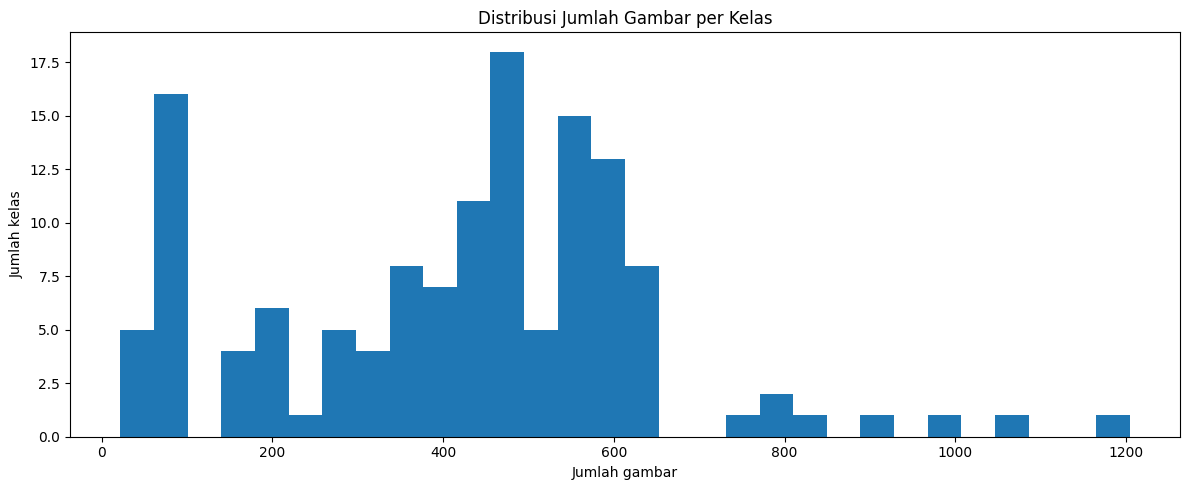

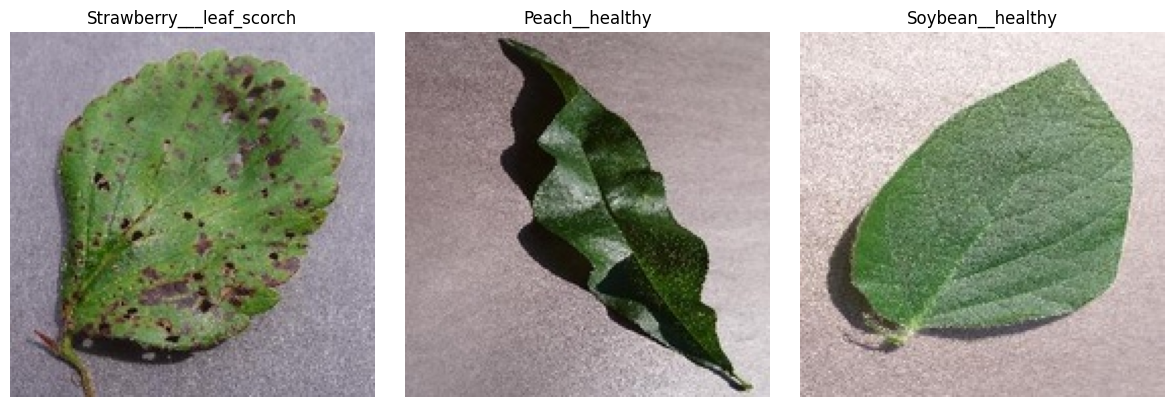

Daftar kelas disimpan ke: data/class_names.json


In [ ]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import json

ZIP_PATH = "data/crop_disease_dataset.zip"
EXTRACT_PATH = "data"
ROOT_DATASET_PATH = "data/dataset_clean_final"


# EKSTRAK ZIP
os.makedirs(EXTRACT_PATH, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

print("Dataset berhasil diekstrak ke:", EXTRACT_PATH)

# VALIDASI DATASET
if not os.path.exists(ROOT_DATASET_PATH):
    raise FileNotFoundError("Folder dataset_clean_final tidak ditemukan!")

print("Root dataset ditemukan:", ROOT_DATASET_PATH)

# LOAD KELAS
classes = sorted([
    d for d in os.listdir(ROOT_DATASET_PATH)
    if os.path.isdir(os.path.join(ROOT_DATASET_PATH, d))
])

print(f"Total kelas ditemukan: {len(classes)}")
print("Contoh 10 kelas pertama:")
for c in classes[:10]:
    print("-", c)

# HITUNG DISTRIBUSI DATA
data = []

for cls in classes:
    cls_path = os.path.join(ROOT_DATASET_PATH, cls)
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    data.append({
        "class_name": cls,
        "num_images": len(images)
    })

df_dist = pd.DataFrame(data).sort_values("num_images", ascending=False)

print("\nStatistik jumlah gambar per kelas:")
print(df_dist["num_images"].describe())

plt.figure(figsize=(12, 5))
plt.hist(df_dist["num_images"], bins=30)
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Jumlah gambar")
plt.ylabel("Jumlah kelas")
plt.tight_layout()
plt.show()

sample_classes = random.sample(classes, min(3, len(classes)))

plt.figure(figsize=(12, 4))

for i, cls in enumerate(sample_classes):
    cls_path = os.path.join(ROOT_DATASET_PATH, cls)
    img_name = random.choice([
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])
    img_path = os.path.join(cls_path, img_name)

    img = Image.open(img_path)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()

CLASS_NAMES_PATH = "data/class_names.json"

with open(CLASS_NAMES_PATH, "w") as f:
    json.dump(classes, f, indent=2)

print("Daftar kelas disimpan ke:", CLASS_NAMES_PATH)


## Filtering Class dengan Pemilihan top 50 class yang mengandung konten terbanyak

In [ ]:
import os
import shutil
import json
import pandas as pd

# Konfigurasi batas tresshold kelas yang memiliki minimal 100 gambar
MIN_IMAGES_PER_CLASS = 100
MAX_CLASSES = 50

ROOT_DATASET_PATH = "data/dataset_clean_final"
FILTERED_ROOT = "data/dataset_filtered"
METADATA_DIR = "metadata"

os.makedirs(FILTERED_ROOT, exist_ok=True)
os.makedirs(METADATA_DIR, exist_ok=True)

classes = sorted([
    d for d in os.listdir(ROOT_DATASET_PATH)
    if os.path.isdir(os.path.join(ROOT_DATASET_PATH, d))
])

print("Total kelas awal:", len(classes))

class_stats = []

for cls in classes:
    cls_path = os.path.join(ROOT_DATASET_PATH, cls)
    num_images = len([
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

    class_stats.append({
        "class_name": cls,
        "num_images": num_images
    })

df_stats = pd.DataFrame(class_stats)

df_filtered = df_stats[df_stats["num_images"] >= MIN_IMAGES_PER_CLASS]
print("Kelas memenuhi threshold:", len(df_filtered))

df_top = (
    df_filtered
    .sort_values("num_images", ascending=False)
    .head(MAX_CLASSES)
    .reset_index(drop=True)
)

#Diambil top 50 kelas dengan konten terbanyak
selected_classes = df_top["class_name"].tolist()
print("Jumlah kelas final:", len(selected_classes))

for cls in selected_classes:
    src_dir = os.path.join(ROOT_DATASET_PATH, cls)
    dst_dir = os.path.join(FILTERED_ROOT, cls)

    if os.path.exists(dst_dir):
        shutil.rmtree(dst_dir)

    shutil.copytree(src_dir, dst_dir)

print("Dataset terfilter disimpan di:", FILTERED_ROOT)

# SIMPAN METADATA
stats_path = os.path.join(METADATA_DIR, "filtered_class_stats.csv")
names_path = os.path.join(METADATA_DIR, "filtered_class_names.json")

df_top.to_csv(stats_path, index=False)

with open(names_path, "w") as f:
    json.dump(selected_classes, f, indent=2)

print("Metadata filtering disimpan:")
print("-", stats_path)
print("-", names_path)


Total kelas awal: 134
Kelas memenuhi threshold: 118
Jumlah kelas final: 50
Dataset terfilter disimpan di: data/dataset_filtered
Metadata filtering disimpan:
- metadata\filtered_class_stats.csv
- metadata\filtered_class_names.json


## Splitting Dataset dengan rasio 80% Training, 10% Validation, 10% Testing

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

DATASET_ROOT = "data/dataset_filtered"
SPLIT_DIR = "splits"
os.makedirs(SPLIT_DIR, exist_ok=True)

RANDOM_STATE = 42
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6


# BUILD DATAFRAME
data = []

for cls in sorted(os.listdir(DATASET_ROOT)):
    cls_path = os.path.join(DATASET_ROOT, cls)
    if not os.path.isdir(cls_path):
        continue

    for img in os.listdir(cls_path):
        if img.lower().endswith((".jpg", ".jpeg", ".png")):
            data.append({
                "filepath": os.path.join(cls_path, img),
                "label": cls
            })

df = pd.DataFrame(data)

print("Total images :", len(df))
print("Total classes:", df["label"].nunique())

# TRAIN / TEMP SPLIT
train_df, temp_df = train_test_split(
    df,
    test_size=(1 - TRAIN_RATIO),
    stratify=df["label"],
    random_state=RANDOM_STATE
)

# VAL / TEST SPLIT=
val_df, test_df = train_test_split(
    temp_df,
    test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
    stratify=temp_df["label"],
    random_state=RANDOM_STATE
)

print("\nSPLIT RESULT")
print("Train :", len(train_df))
print("Val   :", len(val_df))
print("Test  :", len(test_df))

print("\nClass distribution (TRAIN):")
print(train_df["label"].value_counts().describe())


# SAVE SPLITS
train_df.to_csv(os.path.join(SPLIT_DIR, "train.csv"), index=False)
val_df.to_csv(os.path.join(SPLIT_DIR, "val.csv"), index=False)
test_df.to_csv(os.path.join(SPLIT_DIR, "test.csv"), index=False)

print("\nSplit files saved to:", SPLIT_DIR)

Total images : 31487
Total classes: 50

SPLIT RESULT
Train : 25189
Val   : 3149
Test  : 3149

Class distribution (TRAIN):
count     50.000000
mean     503.780000
std      114.869632
min      395.000000
25%      442.000000
50%      472.500000
75%      498.500000
max      963.000000
Name: count, dtype: float64

Split files saved to: splits


## Penerapan Label Encoding

In [ ]:
import pandas as pd
import json
import os

SPLIT_DIR = "splits"
ENCODER_DIR = "encoders"
os.makedirs(ENCODER_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(SPLIT_DIR, "train.csv"))
val_df   = pd.read_csv(os.path.join(SPLIT_DIR, "val.csv"))
test_df  = pd.read_csv(os.path.join(SPLIT_DIR, "test.csv"))

print("Train:", len(train_df))
print("Val  :", len(val_df))
print("Test :", len(test_df))


# LABEL ENCODING (TRAIN ONLY)
class_names = sorted(train_df["label"].unique())
NUM_CLASSES = len(class_names)

label_to_index = {label: idx for idx, label in enumerate(class_names)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

print("Total classes:", NUM_CLASSES)


# APPLY ENCODING
train_df["label_id"] = train_df["label"].map(label_to_index)
val_df["label_id"]   = val_df["label"].map(label_to_index)
test_df["label_id"]  = test_df["label"].map(label_to_index)

assert train_df["label_id"].isnull().sum() == 0
assert val_df["label_id"].isnull().sum() == 0
assert test_df["label_id"].isnull().sum() == 0

# SAVE RESULTS
train_df.to_csv(os.path.join(SPLIT_DIR, "train_encoded.csv"), index=False)
val_df.to_csv(os.path.join(SPLIT_DIR, "val_encoded.csv"), index=False)
test_df.to_csv(os.path.join(SPLIT_DIR, "test_encoded.csv"), index=False)

with open(os.path.join(ENCODER_DIR, "label_to_index.json"), "w") as f:
    json.dump(label_to_index, f, indent=2)

with open(os.path.join(ENCODER_DIR, "index_to_label.json"), "w") as f:
    json.dump(index_to_label, f, indent=2)

print("\nEncoding selesai.")
print("File tersimpan:")
print("- splits/train_encoded.csv")
print("- splits/val_encoded.csv")
print("- splits/test_encoded.csv")
print("- encoders/label_to_index.json")
print("- encoders/index_to_label.json")

Train: 25189
Val  : 3149
Test : 3149
Total classes: 50

Encoding selesai.
File tersimpan:
- splits/train_encoded.csv
- splits/val_encoded.csv
- splits/test_encoded.csv
- encoders/label_to_index.json
- encoders/index_to_label.json


## Preprocessing Dataset

Preprocessing untuk CNN-Base dan CNN Pretrained dipisah, hal ini dikarenakan perbedaan kebutuhan input dan skala data tiap jenis model.
1. CNN Base : Preprocessing cukup sederhana yakni hanya resize gambar, dan normalisasi (0,1)

2. Pretrained Models : Pretrained sudah dilatih pada dataset ImageNet dengan preprocessing tertentu (misal preprocess_input untuk menyesuaikan mean/std pixel).

Pemisahan ini bertujuan untuk menjaga konsistensi input dengan apa yang masing-masing model lihat agar proses training optimal.

### Preprocessing Khusus untuk CNN-Base

In [ ]:
import tensorflow as tf
import pandas as pd
import os

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

SPLIT_DIR = "splits"

# LOAD ENCODED CSV
train_df = pd.read_csv(f"{SPLIT_DIR}/train_encoded.csv")
val_df   = pd.read_csv(f"{SPLIT_DIR}/val_encoded.csv")
test_df  = pd.read_csv(f"{SPLIT_DIR}/test_encoded.csv")

print("Train:", len(train_df))
print("Val  :", len(val_df))
print("Test :", len(test_df))


# PREPROCESS FUNCTION
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


# DATASET BUILDER
def build_dataset(df, shuffle=False):
    paths = df["filepath"].values
    labels = df["label_id"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)

    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)

    return ds

# BUILD DATASETS
train_ds = build_dataset(train_df, shuffle=True)
val_ds   = build_dataset(val_df, shuffle=False)
test_ds  = build_dataset(test_df, shuffle=False)

Train: 25189
Val  : 3149
Test : 3149


### Preprocessing Khusus Untuk Model Pretrained

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SPLIT_DIR = "splits"

train_df = pd.read_csv(f"{SPLIT_DIR}/train_encoded.csv")
val_df   = pd.read_csv(f"{SPLIT_DIR}/val_encoded.csv")
test_df  = pd.read_csv(f"{SPLIT_DIR}/test_encoded.csv")

# CLASS WEIGHT (TRAIN ONLY)
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label_id"]),
    y=train_df["label_id"]
)

class_weight = {
    i: w for i, w in enumerate(class_weights_array)
}

print("Class weight:", class_weight)


# SHARED PREPROCESSING
# ini adalah preprocessing sederhana yang akan digunakan oleh kedua model pretrained
def preprocess_basic(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)  # 0–255
    return image, label

def build_base_dataset(df, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["filepath"].values, df["label_id"].values)
    )

    if shuffle:
        ds = ds.shuffle(len(df), reshuffle_each_iteration=True)

    ds = ds.map(preprocess_basic, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

base_train_ds = build_base_dataset(train_df, shuffle=True)
base_val_ds   = build_base_dataset(val_df)
base_test_ds  = build_base_dataset(test_df)


# MODEL-SPECIFIC PREPROCESS
# pada tahap ini, masing-masing model akan menggunakan pretrained yang sudah dilatih pada dataset ImageNet dengan preprocessing tertentu
def preprocess_for_efficientnet(image, label):
    return efficientnet_preprocess(image), label

def preprocess_for_mobilenet(image, label):
    return mobilenet_preprocess(image), label

train_ds_efficientnet = base_train_ds.map(preprocess_for_efficientnet, num_parallel_calls=AUTOTUNE)
val_ds_efficientnet   = base_val_ds.map(preprocess_for_efficientnet, num_parallel_calls=AUTOTUNE)
test_ds_efficientnet  = base_test_ds.map(preprocess_for_efficientnet, num_parallel_calls=AUTOTUNE)

train_ds_mobilenet = base_train_ds.map(preprocess_for_mobilenet, num_parallel_calls=AUTOTUNE)
val_ds_mobilenet   = base_val_ds.map(preprocess_for_mobilenet, num_parallel_calls=AUTOTUNE)
test_ds_mobilenet  = base_test_ds.map(preprocess_for_mobilenet, num_parallel_calls=AUTOTUNE)




Class weight: {0: np.float64(0.5231360332294912), 1: np.float64(1.0260285132382891), 2: np.float64(1.25318407960199), 3: np.float64(1.0473596673596675), 4: np.float64(1.00756), 5: np.float64(1.1798126463700234), 6: np.float64(1.1372009029345373), 7: np.float64(1.1397737556561085), 8: np.float64(1.1120971302428255), 9: np.float64(1.1397737556561085), 10: np.float64(0.7667884322678843), 11: np.float64(1.0927982646420824), 12: np.float64(0.9782135922330097), 13: np.float64(0.9878039215686274), 14: np.float64(1.1909692671394798), 15: np.float64(1.0787580299785868), 16: np.float64(0.852419627749577), 17: np.float64(1.0539330543933054), 18: np.float64(1.0473596673596675), 19: np.float64(1.0365843621399178), 20: np.float64(1.1295515695067264), 21: np.float64(1.0605894736842105), 22: np.float64(0.9801167315175098), 23: np.float64(0.7798452012383901), 24: np.float64(0.7946056782334385), 25: np.float64(1.0951739130434783), 26: np.float64(1.1397737556561085), 27: np.float64(1.1397737556561085), 2

## Model CNN-Base

### Konfigurasi Model CNN-Base (No Pretrained)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

NUM_CLASSES = 50  # Sesuai dataset filtered
INPUT_SHAPE = (128, 128, 3)

def build_cnn_base_light():
    model = models.Sequential([
        layers.Input(shape=INPUT_SHAPE),

        # Block 1
        layers.Conv2D(32, 3, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(32, 3, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),

        # Block 2
        layers.Conv2D(64, 3, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(64, 3, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),

        # Block 3
        layers.Conv2D(128, 3, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(128, 3, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),

        # Global pooling & dense
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation="softmax")
    ])
    return model

cnn_base_model = build_cnn_base_light()

cnn_base_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             

 Total params: 334,674 (1.28 MB)

 Trainable params: 333,778 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

### Training Model CNN-Base (No Pretrained)

In [ ]:
import tensorflow as tf
import os

EPOCHS = 20
BATCH_SIZE = 32
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "cnn_base_best.keras"),
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

cnn_base_history = cnn_base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb]
)

print(f"Training selesai. Model terbaik tersimpan di {MODEL_DIR}/cnn_base_best.keras")

Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.2597 - loss: 2.7303
Epoch 1: val_accuracy improved from -inf to 0.27342, saving model to /content/models/cnn_base_best.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 157s 163ms/step - accuracy: 0.2599 - loss: 2.7297 - val_accuracy: 0.2734 - val_loss: 3.0386
Epoch 2/20
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5127 - loss: 1.5911
Epoch 2: val_accuracy improved from 0.27342 to 0.53509, saving model to /content/models/cnn_base_best.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 116s 147ms/step - accuracy: 0.5128 - loss: 1.5908 - val_accuracy: 0.5351 - val_loss: 1.5573
Epoch 3/20
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5926 - loss: 1.2998
Epoch 3: val_accuracy improved from 0.53509 to 0.55224, saving model to /content/models/cnn_base_best.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 117s 149ms/step - accuracy: 0.5927 - loss: 1.2996 - val_accuracy: 0.5522 - val_loss: 1.4445
Epoch 4/20
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/ste

### Visualisasi dan Classification Report Model CNN-Base (No Pretrained)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━

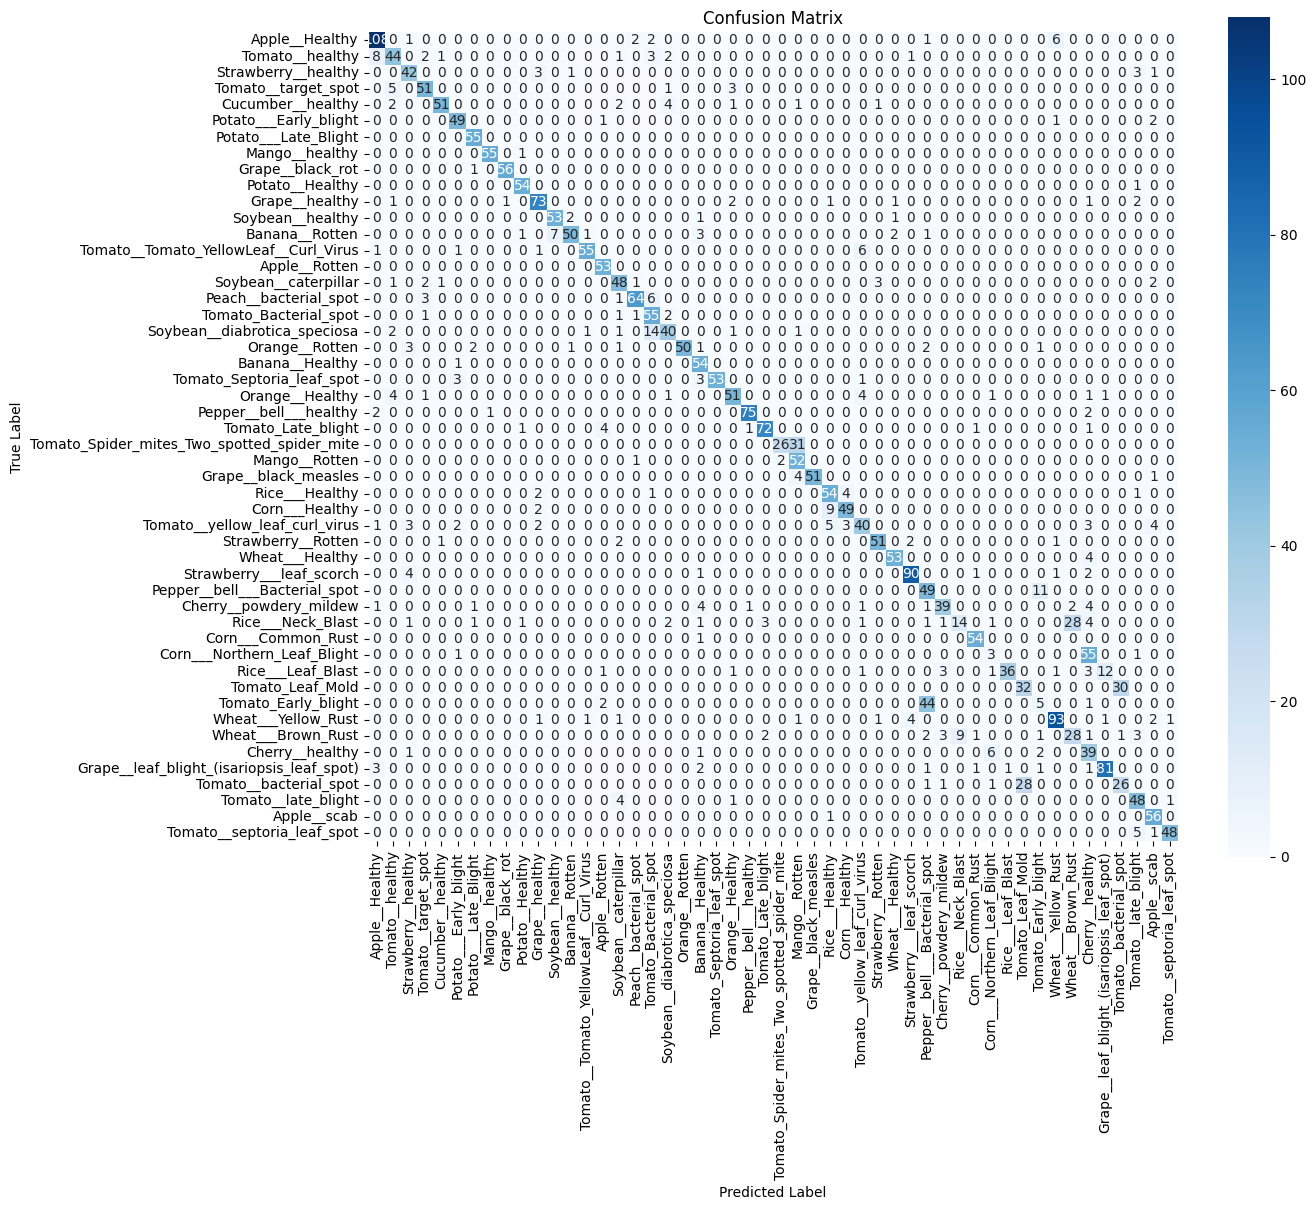

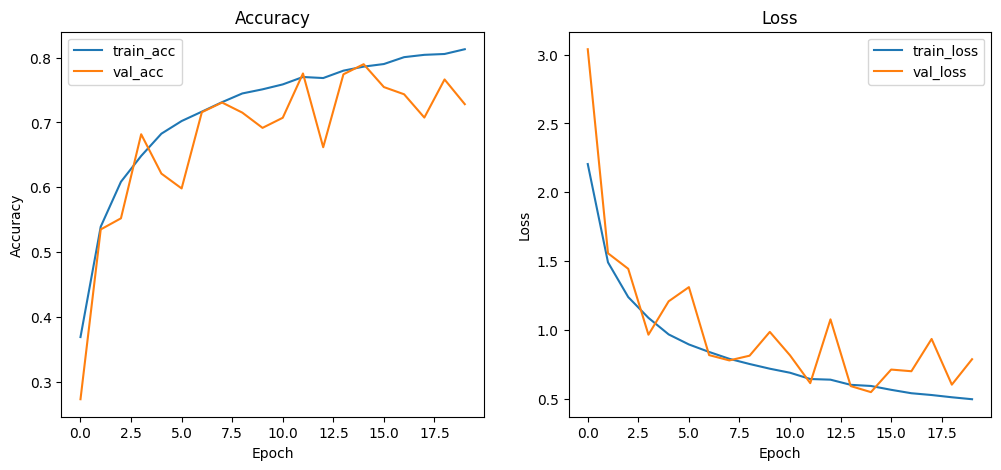

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import json

with open("metadata/filtered_class_names.json") as f:
    class_names = json.load(f)
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = cnn_base_model.predict(images)
    preds_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_classes)

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)
print("=== Classification Report ===")
print(report)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14,12))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    square=True
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(cnn_base_history.history['accuracy'], label='train_acc')
plt.plot(cnn_base_history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_base_history.history['loss'], label='train_loss')
plt.plot(cnn_base_history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()



## Model Pretrained - EfficientNetB0

### Konfigurasi Model EfficientNetB0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 50
IMAGE_SIZE = (224, 224, 3)
DROPOUT_RATE = 0.3
LEARNING_RATE = 1e-4

# LOAD PRETRAINED
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SIZE,
    pooling="avg"
)

base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.85)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# BUILD CLASSIFICATION HEAD
inputs = tf.keras.Input(shape=IMAGE_SIZE)

x = base_model(inputs, training=False)
x = layers.BatchNormalization()(x)
x = layers.Dense(
    256,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)

x = layers.Dropout(DROPOUT_RATE)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

efficientnet_model = models.Model(inputs, outputs)

efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

efficientnet_model.summary()



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,395,477 (16.77 MB)

 Trainable params: 2,282,258 (8.71 MB)

 Non-trainable params: 2,113,219 (8.06 MB)

In [13]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "efficientnet_best_finetune.keras"),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


efficientnet_history = efficientnet_model.fit(
    train_ds_efficientnet,
    validation_data=val_ds_efficientnet,
    epochs=20,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, earlystop_cb]
)

print("Training selesai. Model terbaik tersimpan di efficientnet_best_finetune.keras")

Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4958 - loss: 2.0624
Epoch 1: val_loss improved from inf to 0.39516, saving model to /content/models/efficientnet_best_finetune.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 122s 104ms/step - accuracy: 0.4960 - loss: 2.0613 - val_accuracy: 0.8581 - val_loss: 0.3952
Epoch 2/20
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8452 - loss: 0.4818
Epoch 2: val_loss improved from 0.39516 to 0.31092, saving model to /content/models/efficientnet_best_finetune.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8452 - loss: 0.4817 - val_accuracy: 0.8857 - val_loss: 0.3109
Epoch 3/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8884 - loss: 0.3423
Epoch 3: val_loss improved from 0.31092 to 0.27153, saving model to /content/models/efficientnet_best_finetune.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.8884 - loss: 0.3423 - val_accuracy: 0.8923 - val_loss: 0.2715
Epoch 4/20
788/788 ━━━━━━━━━━━━━━

### Visualisasi dan Classification Report Model EfficientNetB0

===== EVALUASI MODEL =====
Accuracy : 0.8955

Classification Report:
              precision    recall  f1-score   support

           0     0.9916    0.9833    0.9874       120
           1     1.0000    0.9839    0.9919        62
           2     0.9423    0.9800    0.9608        50
           3     0.9836    1.0000    0.9917        60
           4     1.0000    1.0000    1.0000        62
           5     1.0000    0.9811    0.9905        53
           6     1.0000    1.0000    1.0000        55
           7     1.0000    1.0000    1.0000        56
           8     0.9828    1.0000    0.9913        57
           9     1.0000    1.0000    1.0000        55
          10     1.0000    0.9878    0.9939        82
          11     1.0000    1.0000    1.0000        57
          12     1.0000    1.0000    1.0000        65
          13     0.9697    1.0000    0.9846        64
          14     1.0000    1.0000    1.0000        53
          15     0.9828    0.9828    0.9828        58
          16

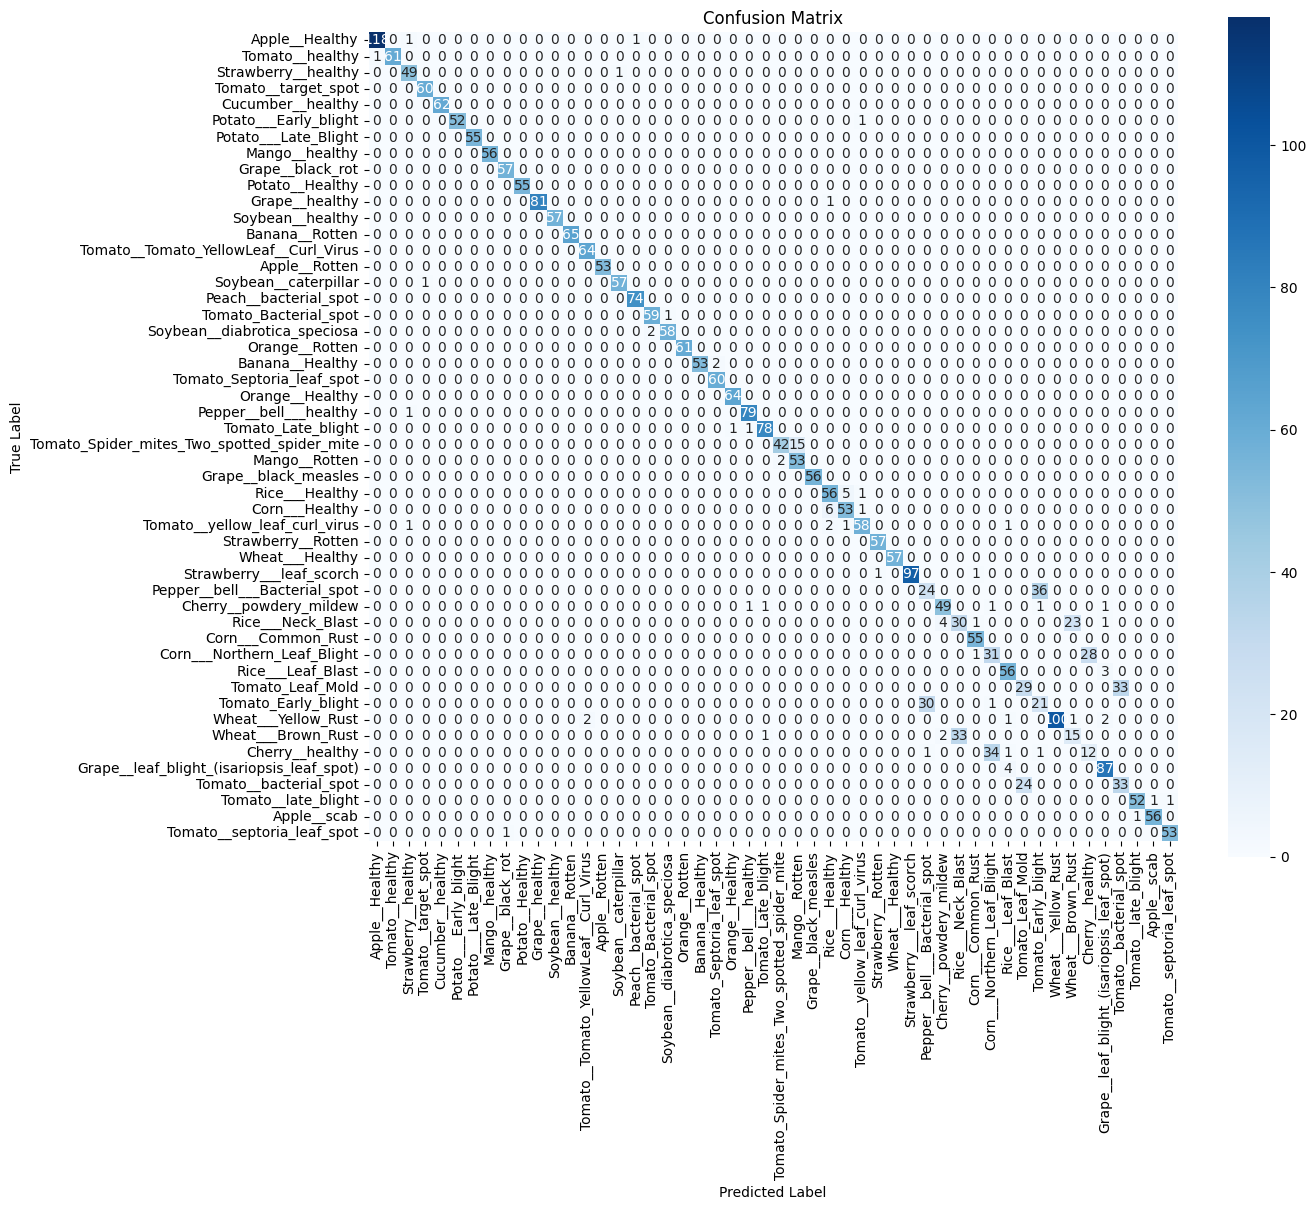

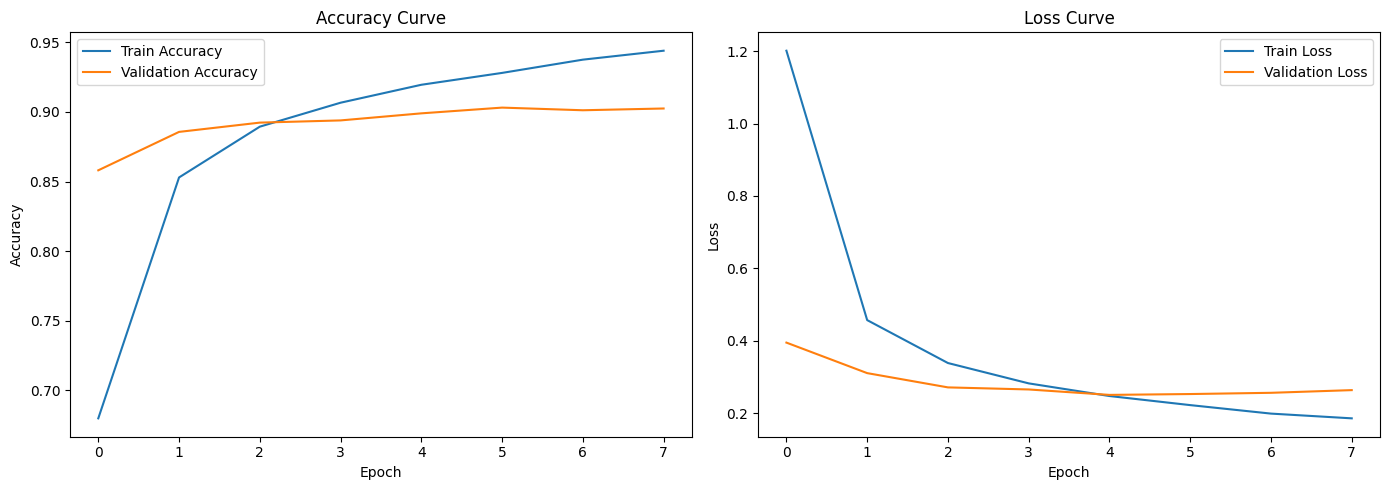

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


with open("metadata/filtered_class_names.json") as f:
    class_names = json.load(f)

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix
)

y_true = []
y_pred = []

for images, labels in test_ds_efficientnet:
    preds = efficientnet_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("===== EVALUASI MODEL =====")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}\n")

print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    digits=4
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14,12))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    square=True
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(efficientnet_history.history["accuracy"], label="Train Accuracy")
plt.plot(efficientnet_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(efficientnet_history.history["loss"], label="Train Loss")
plt.plot(efficientnet_history.history["val_loss"], label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


## Model Pretrained 2 - MobileNetV3Small

### Konfigurasi Model MobileNetV3Small

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV3Small

NUM_CLASSES = 50
IMAGE_SIZE = (224, 224, 3)
DROPOUT_RATE = 0.4
LEARNING_RATE = 1e-4

# LOAD PRETRAINED BASE
base_model = MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SIZE,
    pooling="avg"
)

base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.9)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


# BUILD HEAD
inputs = tf.keras.Input(shape=IMAGE_SIZE)
x = base_model(inputs)
x = layers.Dense(
    128,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = layers.Dropout(DROPOUT_RATE)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_mobilenet = models.Model(inputs, outputs)

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_mobilenet.summary()


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 576)            │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,019,426 (3.89 MB)

 Trainable params: 374,402 (1.43 MB)

 Non-trainable params: 645,024 (2.46 MB)

### Training Model MobileNetV3Small

In [ ]:
import tensorflow as tf
import os

MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)


# CALLBACKS
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "mobilenetv3_best.keras"),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


# TRAINING
history_mobilenet = model_mobilenet.fit(
    train_ds_mobilenet,
    validation_data=val_ds_mobilenet,
    epochs=20,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

print("Training selesai. Model terbaik tersimpan di mobilenetv3_best.keras")


Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2060 - loss: 3.1610
Epoch 1: val_loss improved from inf to 1.19282, saving model to /content/models/mobilenetv3_best.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 94s 81ms/step - accuracy: 0.2062 - loss: 3.1601 - val_accuracy: 0.7107 - val_loss: 1.1928 - learning_rate: 1.0000e-04
Epoch 2/20
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6518 - loss: 1.2006
Epoch 2: val_loss improved from 1.19282 to 0.71353, saving model to /content/models/mobilenetv3_best.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.6519 - loss: 1.2001 - val_accuracy: 0.8015 - val_loss: 0.7135 - learning_rate: 1.0000e-04
Epoch 3/20
786/788 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7509 - loss: 0.8065
Epoch 3: val_loss improved from 0.71353 to 0.54204, saving model to /content/models/mobilenetv3_best.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.7509 - loss: 0.8064 - val_accuracy: 0.8323 - val_loss: 0.5420 - learnin

### Visualisasi dan Classfication Report MobileNetV3Small

===== EVALUASI MODEL =====
Accuracy : 0.8847

Classification Report:
                                             precision    recall  f1-score   support

                             Apple__Healthy     0.9754    0.9917    0.9835       120
                            Tomato__healthy     0.9242    0.9839    0.9531        62
                        Strawberry__healthy     0.9792    0.9400    0.9592        50
                        Tomato__target_spot     1.0000    1.0000    1.0000        60
                          Cucumber__healthy     1.0000    1.0000    1.0000        62
                      Potato___Early_blight     0.9811    0.9811    0.9811        53
                       Potato___Late_Blight     1.0000    1.0000    1.0000        55
                             Mango__healthy     1.0000    1.0000    1.0000        56
                           Grape__black_rot     1.0000    0.9825    0.9912        57
                            Potato__Healthy     0.9649    1.0000    0.9821      

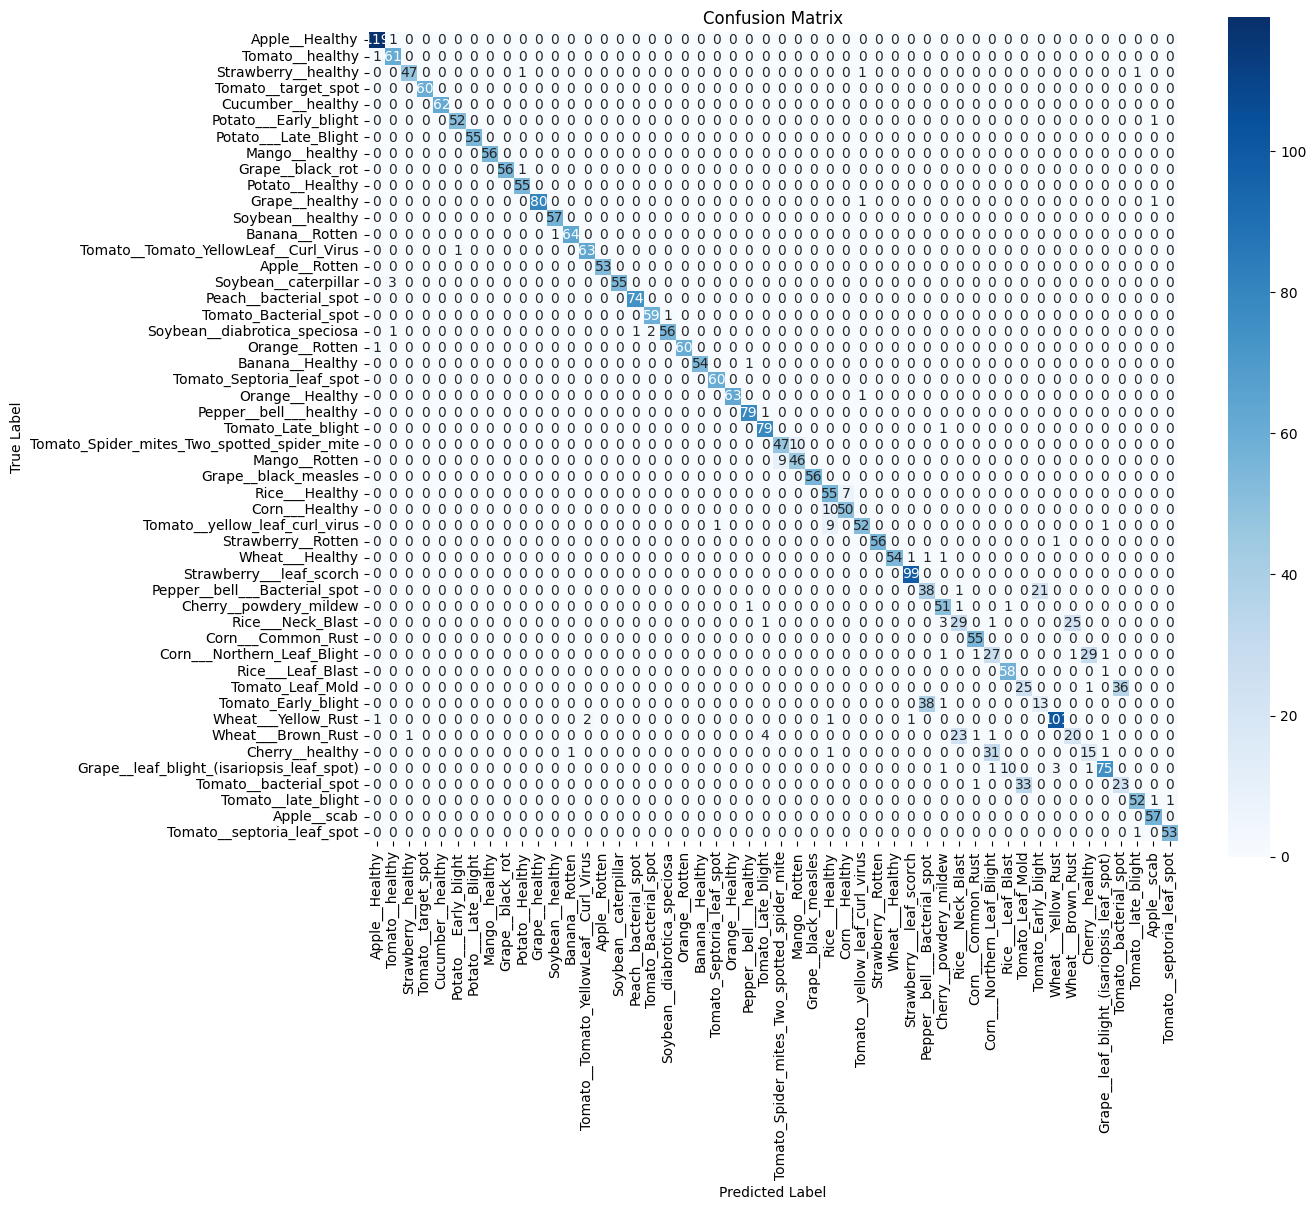

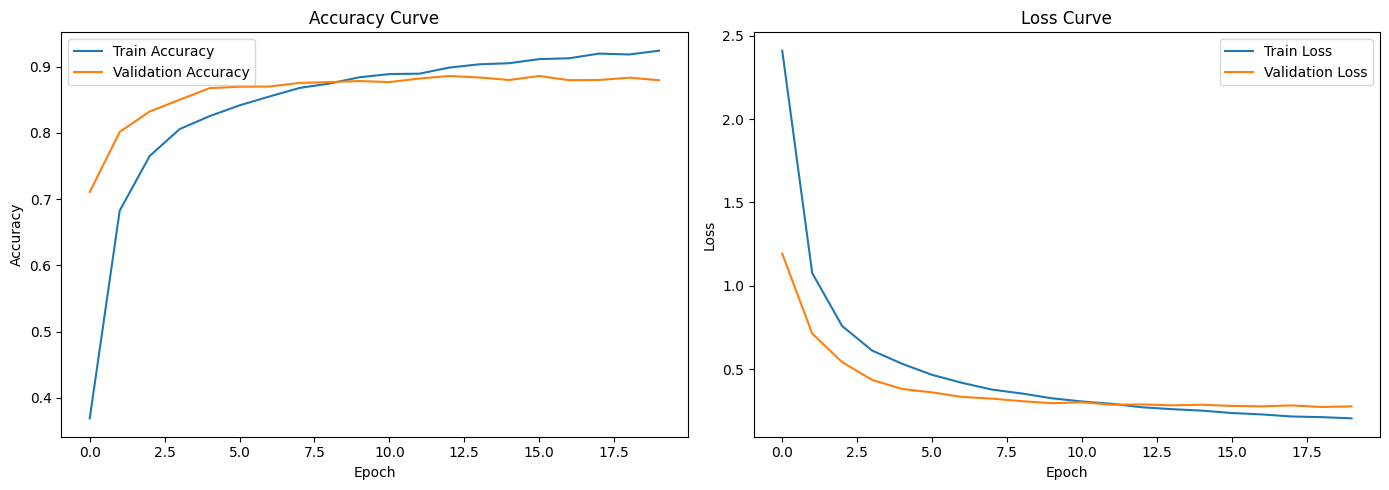

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


with open("metadata/filtered_class_names.json") as f:
    class_names = json.load(f)

y_true = []
y_pred = []

for images, labels in test_ds_mobilenet:
    preds = model_mobilenet.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("===== EVALUASI MODEL =====")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}\n")

print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14,12))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    square=True
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_mobilenet.history["accuracy"], label="Train Accuracy")
plt.plot(history_mobilenet.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_mobilenet.history["loss"], label="Train Loss")
plt.plot(history_mobilenet.history["val_loss"], label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
